In [1]:
!pip install pyriemann

     |████████████████████████████████| 42 kB 429 kB/s             
  Preparing metadata (setup.py) ... - done
  Created wheel for pyriemann: filename=pyriemann-0.2.7-py2.py3-none-any.whl size=49770 sha256=df676a704a045531dc2ff0788a61985012668fe1884f82bfcde1c234c24dc2b6
  Stored in directory: /root/.cache/pip/wheels/5c/b7/55/27dcb08ed8fb58da8c1be108c23928ffb9125c9c1da2ddfb53
Successfully built pyriemann


In [2]:
!pip install pipe

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import accuracy_score
from datetime import datetime
import gc # Garbage Collector interface

import mne
from mne.preprocessing import ICA
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
from pipe import * 
import pyriemann

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/decoding-the-human-brain/test_17_23.zip
/kaggle/input/decoding-the-human-brain/train_07_12.zip
/kaggle/input/decoding-the-human-brain/random_submission.csv
/kaggle/input/decoding-the-human-brain/train_01_06.zip
/kaggle/input/decoding-the-human-brain/train_13_16.zip


# Loading From Kaggle

## *Train Files*

In [4]:
!unzip "../input/decoding-the-human-brain/train_01_06.zip" -d ./train
!unzip "../input/decoding-the-human-brain/train_07_12.zip" -d ./train
!unzip "../input/decoding-the-human-brain/train_13_16.zip" -d ./train

Archive:  ../input/decoding-the-human-brain/train_01_06.zip
  inflating: ./train/data/train_subject01.mat  
  inflating: ./train/data/train_subject02.mat  
  inflating: ./train/data/train_subject03.mat  
  inflating: ./train/data/train_subject04.mat  
  inflating: ./train/data/train_subject05.mat  
  inflating: ./train/data/train_subject06.mat  
Archive:  ../input/decoding-the-human-brain/train_07_12.zip
  inflating: ./train/data/train_subject07.mat  
  inflating: ./train/data/train_subject08.mat  
  inflating: ./train/data/train_subject09.mat  
  inflating: ./train/data/train_subject10.mat  
  inflating: ./train/data/train_subject11.mat  
  inflating: ./train/data/train_subject12.mat  
Archive:  ../input/decoding-the-human-brain/train_13_16.zip
  inflating: ./train/data/train_subject13.mat  
  inflating: ./train/data/train_subject14.mat  
  inflating: ./train/data/train_subject15.mat  
  inflating: ./train/data/train_subject16.mat  


## *Test Files*

In [5]:
!unzip "../input/decoding-the-human-brain/test_17_23.zip" -d ./test

Archive:  ../input/decoding-the-human-brain/test_17_23.zip
  inflating: ./test/data/test_subject17.mat  
  inflating: ./test/data/test_subject18.mat  
  inflating: ./test/data/test_subject19.mat  
  inflating: ./test/data/test_subject20.mat  
  inflating: ./test/data/test_subject21.mat  
  inflating: ./test/data/test_subject22.mat  
  inflating: ./test/data/test_subject23.mat  


In [6]:
train_folder = './train/data'
test_folder = './test/data'

train_files = sorted(os.listdir(train_folder))
test_files = sorted(os.listdir(test_folder))

In [7]:
for i , file in enumerate(train_files):
    print(f'i = {i+1} | File = {file}')
    
print(f'\nExample For A Full Path {train_folder}/{file}')

i = 1 | File = train_subject01.mat
i = 2 | File = train_subject02.mat
i = 3 | File = train_subject03.mat
i = 4 | File = train_subject04.mat
i = 5 | File = train_subject05.mat
i = 6 | File = train_subject06.mat
i = 7 | File = train_subject07.mat
i = 8 | File = train_subject08.mat
i = 9 | File = train_subject09.mat
i = 10 | File = train_subject10.mat
i = 11 | File = train_subject11.mat
i = 12 | File = train_subject12.mat
i = 13 | File = train_subject13.mat
i = 14 | File = train_subject14.mat
i = 15 | File = train_subject15.mat
i = 16 | File = train_subject16.mat

Example For A Full Path ./train/data/train_subject16.mat


# Data Exploration


In [8]:
train_file = './train/data/train_subject01.mat'
train_sample = loadmat(train_file, squeeze_me=True)

n_trials , n_channels , time  = train_sample['X'].shape
sampling_freq = int( train_sample['sfreq'] )  # in Hertz

train_sample

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sat Apr  5 19:16:41 2014',
 '__version__': '1.0',
 '__globals__': [],
 'tmin': -0.5,
 'tmax': 1.0,
 'sfreq': 250.0,
 'y': array([0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,

In [9]:
# Showing The All Files Have The Same Channels Shape
for file in train_files:
    print(f'Current File: {file}')
    subject = loadmat(f'{train_folder}/{file}', squeeze_me=True)
    print(subject['X'].shape)

Current File: train_subject01.mat
(594, 306, 375)
Current File: train_subject02.mat
(586, 306, 375)
Current File: train_subject03.mat
(578, 306, 375)
Current File: train_subject04.mat
(594, 306, 375)
Current File: train_subject05.mat
(586, 306, 375)
Current File: train_subject06.mat
(588, 306, 375)
Current File: train_subject07.mat
(588, 306, 375)
Current File: train_subject08.mat
(592, 306, 375)
Current File: train_subject09.mat
(594, 306, 375)
Current File: train_subject10.mat
(590, 306, 375)
Current File: train_subject11.mat
(592, 306, 375)
Current File: train_subject12.mat
(586, 306, 375)
Current File: train_subject13.mat
(588, 306, 375)
Current File: train_subject14.mat
(588, 306, 375)
Current File: train_subject15.mat
(580, 306, 375)
Current File: train_subject16.mat
(590, 306, 375)


In [10]:
"""
Test File is different from train 
    1) does not as y field
    2) has ID field to use in submission
    3) has the same length as trials
"""

test_file = './test/data/test_subject20.mat'
test_sample = loadmat(test_file, squeeze_me=True)

print(test_sample['X'].shape[0] == test_sample['Id'].shape[0])

test_sample


True


{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sat Apr  5 19:18:01 2014',
 '__version__': '1.0',
 '__globals__': [],
 'tmin': -0.5,
 'tmax': 1.0,
 'sfreq': 250.0,
 'X': array([[[ 2.08451624e-11,  2.13732382e-11,  1.03177996e-11, ...,
          -3.19431764e-12, -5.13467394e-12, -6.65500034e-12],
         [ 2.75252581e-11,  3.59376036e-11,  3.19850119e-11, ...,
           1.07275267e-12,  3.25852604e-12,  2.99812410e-12],
         [ 4.43762567e-13,  4.82227431e-13,  5.62073107e-14, ...,
          -7.67984241e-14, -3.33353171e-14, -1.86597591e-13],
         ...,
         [ 6.27394404e-12,  3.28481253e-12, -9.75455740e-12, ...,
           1.25592895e-13, -4.16318889e-12,  3.81809081e-12],
         [ 2.19290298e-12, -4.11449737e-12,  1.84530031e-13, ...,
          -1.27512562e-12,  4.54945239e-12,  6.30722254e-12],
         [-8.21351179e-14, -2.38764612e-14,  5.19395758e-14, ...,
          -4.24684634e-14, -2.52355103e-14,  4.89444605e-14]],
 
        [[ 7.18825130e-12,  

# Data Visualization

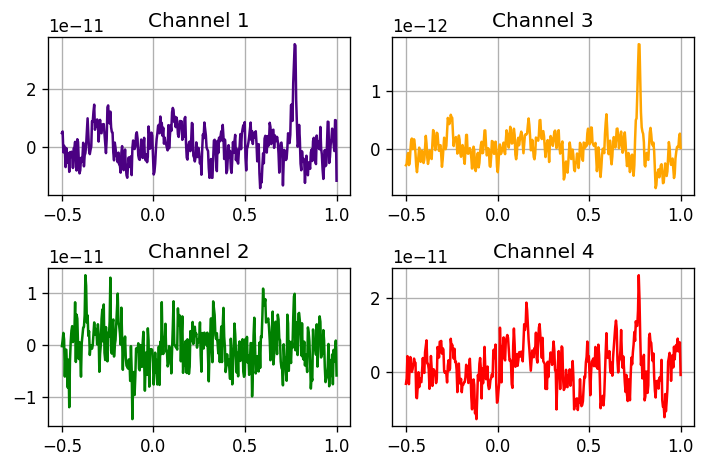

In [11]:
time = np.linspace(-0.5 , 1.0 , 375) # X axis => start , End , N_division
amplitudes = train_sample['X'][0]

fig, axs = plt.subplots(2, 2)
fig.set_dpi(120)

axs[0, 0].plot(time, amplitudes[0],color='indigo')
axs[0, 0].set_title("Channel 1")
axs[0,0].grid(True)

axs[1, 0].plot(time, amplitudes[1],color='green')
axs[1, 0].set_title("Channel 2")
axs[1,0].grid(True)

axs[0, 1].plot(time, amplitudes[2] ,color='orange')
axs[0, 1].set_title("Channel 3")
axs[0,1].grid(True)

axs[1, 1].plot(time , amplitudes[3] , color='red')
axs[1, 1].set_title("Channel 4")
axs[1,1].grid(True)

fig.tight_layout()


# Transfer To MNE

In [12]:
ch_names = [f'MEG{n:}' for n in range(n_channels)]
ch_types = ['mag'] * n_channels
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
print(info)


<Info | 7 non-empty values
 bads: []
 ch_names: MEG0, MEG1, MEG2, MEG3, MEG4, MEG5, MEG6, MEG7, MEG8, MEG9, ...
 chs: 306 Magnetometers
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 306
 projs: []
 sfreq: 250.0 Hz
>


In [13]:
info.set_montage('standard_1020')


<Info | 8 non-empty values
 bads: []
 ch_names: MEG0, MEG1, MEG2, MEG3, MEG4, MEG5, MEG6, MEG7, MEG8, MEG9, ...
 chs: 306 Magnetometers
 custom_ref_applied: False
 dig: 3 items (3 Cardinal)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 306
 projs: []
 sfreq: 250.0 Hz
>

Creating RawArray with float64 data, n_channels=306, n_times=375
    Range : 0 ... 374 =      0.000 ...     1.496 secs
Ready.
Using matplotlib as 2D backend.


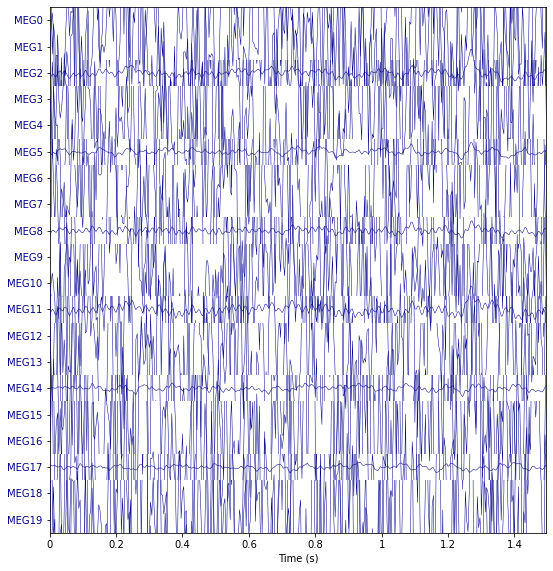

In [14]:
simulated_raw = mne.io.RawArray(train_sample['X'][0], info)
simulated_raw.plot(show_scrollbars=False, show_scalebars=False )
print("")

In [15]:
simulated_epochs = mne.EpochsArray(train_sample['X'], info  )
simulated_epochs.get_data().shape

Not setting metadata
Not setting metadata
594 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


(594, 306, 375)

Not setting metadata
Not setting metadata
594 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


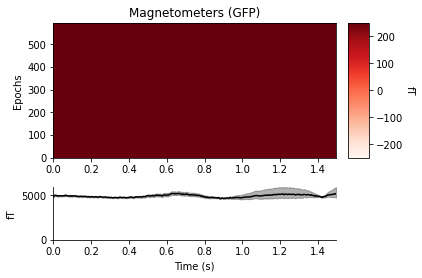

Channel Names Are
['MEG0', 'MEG1', 'MEG2', 'MEG3', 'MEG4', 'MEG5', 'MEG6', 'MEG7', 'MEG8', 'MEG9', 'MEG10', 'MEG11', 'MEG12', 'MEG13', 'MEG14', 'MEG15', 'MEG16', 'MEG17', 'MEG18', 'MEG19', 'MEG20', 'MEG21', 'MEG22', 'MEG23', 'MEG24', 'MEG25', 'MEG26', 'MEG27', 'MEG28', 'MEG29', 'MEG30', 'MEG31', 'MEG32', 'MEG33', 'MEG34', 'MEG35', 'MEG36', 'MEG37', 'MEG38', 'MEG39', 'MEG40', 'MEG41', 'MEG42', 'MEG43', 'MEG44', 'MEG45', 'MEG46', 'MEG47', 'MEG48', 'MEG49', 'MEG50', 'MEG51', 'MEG52', 'MEG53', 'MEG54', 'MEG55', 'MEG56', 'MEG57', 'MEG58', 'MEG59', 'MEG60', 'MEG61', 'MEG62', 'MEG63', 'MEG64', 'MEG65', 'MEG66', 'MEG67', 'MEG68', 'MEG69', 'MEG70', 'MEG71', 'MEG72', 'MEG73', 'MEG74', 'MEG75', 'MEG76', 'MEG77', 'MEG78', 'MEG79', 'MEG80', 'MEG81', 'MEG82', 'MEG83', 'MEG84', 'MEG85', 'MEG86', 'MEG87', 'MEG88', 'MEG89', 'MEG90', 'MEG91', 'MEG92', 'MEG93', 'MEG94', 'MEG95', 'MEG96', 'MEG97', 'MEG98', 'MEG99', 'MEG100', 'MEG101', 'MEG102', 'MEG103', 'MEG104', 'MEG105', 'MEG106', 'MEG107', 'MEG108', '

In [16]:
mne.viz.plot_epochs_image(simulated_epochs,sigma=.5,
                           vmin=-250, vmax=250,
                           show=True)
print("Channel Names Are")
print(info['ch_names'])


    Using multitaper spectrum estimation with 7 DPSS windows


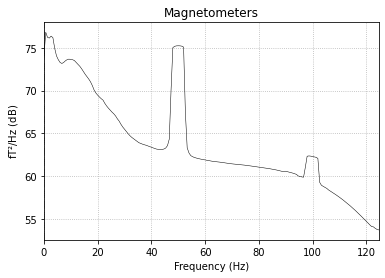

For All Epochs For The Same Subject


In [17]:
fig, ax = plt.subplots(ncols=1)

simulated_epochs.plot_psd(area_mode=None, ax=ax,
                              average=True, spatial_colors=True)

print("For All Epochs For The Same Subject")

# Preprocessing

## *Removing Artifacts Using ICA*


In [18]:
print(f'Before Applying ICA Shape is {simulated_epochs.get_data().shape}')
simulated_epochs.filter(l_freq=1., h_freq=None)
ica = ICA(n_components=25, max_iter='auto', method='fastica', random_state=23).fit(simulated_epochs)


Before Applying ICA Shape is (594, 306, 375)
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/299336839.py:2: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  simulated_epochs.filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 21.9s.


Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


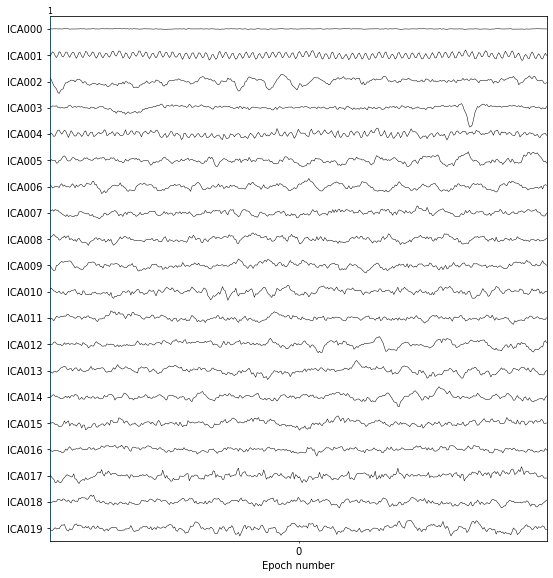

This For A Single Epoch


In [19]:
ica.plot_sources(simulated_epochs[0], show_scrollbars=False)
print("This For A Single Epoch")

Not setting metadata
Not setting metadata
594 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


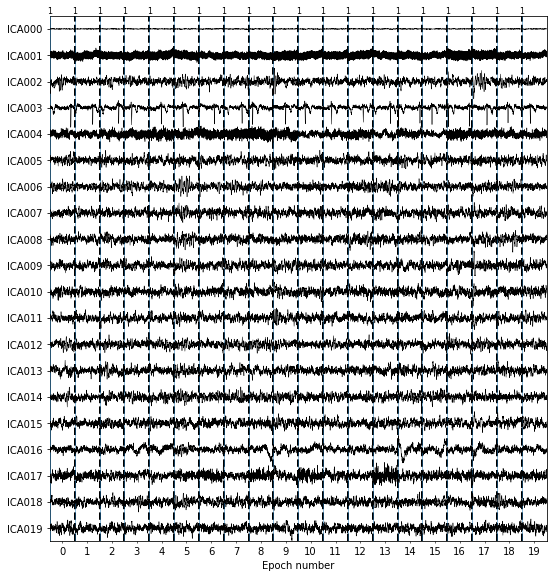

This For All Epochs


In [20]:
ica.plot_sources(simulated_epochs, show_scrollbars=False)
print("This For All Epochs")

In [21]:
#help(ica)
epochs_without_artifacts = ica.apply(simulated_epochs)
epochs_without_artifacts.get_data().shape

Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


(594, 306, 375)

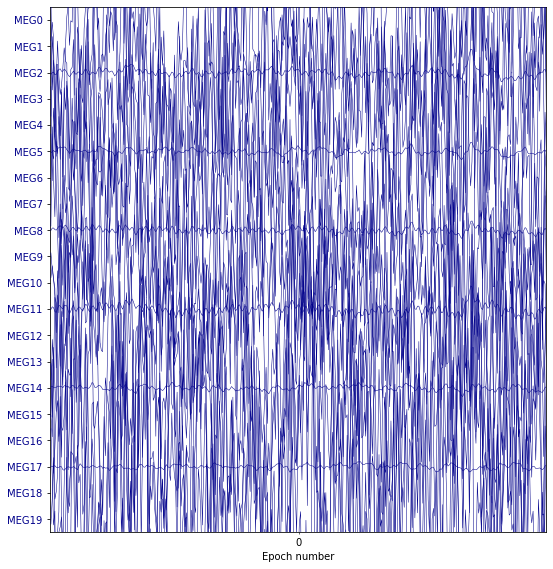

For Single Epoch


In [22]:
epochs_without_artifacts[0].plot(show_scrollbars=False, show_scalebars=False )
print("For Single Epoch")

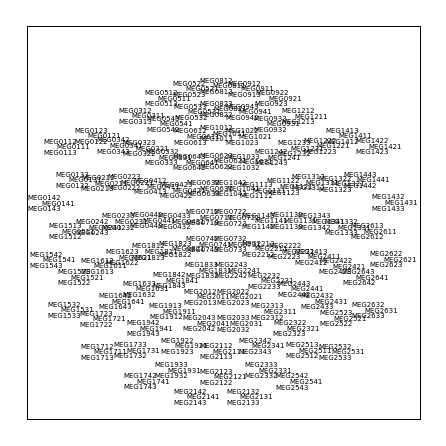

Layout For The MEG Sensors


In [23]:
layout = mne.channels.find_layout(info , ch_type="meg")
layout.plot()
print("Layout For The MEG Sensors")

## Deleting Previous Variables Duo to Memory Constraints in Kaggle

In [24]:
del train_sample , test_sample
del subject
del time , amplitudes
del fig , axs
del ch_names , ch_types , info
del simulated_raw , simulated_epochs
del ica , epochs_without_artifacts , layout

gc.collect()

220192

# Pipeline Functions

In [25]:
@Pipe
def load_mat_file ( parameters_dict : dict ) -> dict :
    '''
    reading mat files and get the X and y from them

    Parameters:
        dictionary of two keys
            (file): Path of the mat file.
            (is_train_file): bool to know if this file is train or test file

    Returns:
        dictionary of three keys
            (X): np array, X data of this file.
            (y): np array, y data if this is a train file and ID`s if this is test file
            (is_train_file): bool to know if this file is train or test file

    '''
    subject = loadmat(parameters_dict['file'], squeeze_me=True)
    is_train_file = parameters_dict['is_train_file'] 
    X = subject['X']
    y = subject['y'] if is_train_file else subject['Id']
    
    return { 'X' : X , 'y' : y , "is_train_file" :  is_train_file }

@Pipe
def transform_np_to_mne (parameters_dict : dict ) -> dict:
    '''
    trasform numpy arrays to mne objcet to be usefull in plotting or filtering it 

    Parameters:
        dictionary of three keys
            (X): X data of this file as num.
            (y): y data if this is a train file and ID`s if this is test file
            (is_train_file): bool to know if this file is train or test file

    Returns:
        dictionary of three keys
            (mne_epochs): X data as epochs from mne object
            (y): y data and it has no changes
            (is_train_file): bool to know if this file is train or test file

    '''
    n_channels = 306
    sampling_freq = 250
    channels_names = [f'MEG{n:}' for n in range(n_channels)]
    channels_types = ['mag'] * n_channels
    info = mne.create_info(channels_names , ch_types=channels_types , sfreq=sampling_freq)
    mne_epochs = mne.EpochsArray(parameters_dict['X'], info)
    
    y = parameters_dict['y']
    is_train_file = parameters_dict['is_train_file'] 

    return { "mne_epochs" : mne_epochs , 'y' : y , "is_train_file" :  is_train_file}


@Pipe
def remove_artifacts_from_mne (parameters_dict : dict ) -> dict:
    '''
    removing the artifacts from mne object by applying ICA to its epochs 

    Parameters:
        dictionary of three keys
            (mne_epochs): X data as epochs from mne object
            (y): y data and it has no changes
            (is_train_file): bool to know if this file is train or test file

    Returns:
        dictionary of three keys
            (mne_epochs_clean): clean epochs to use in training the model 
            (y): y data and it has no changes
            (is_train_file): bool to know if this file is train or test file


    '''
    clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)
    ica = ICA(n_components=25, max_iter='auto', method='fastica', random_state=23).fit(clean_epochs)
    clean_epochs = ica.apply(clean_epochs)
    
    y = parameters_dict['y']
    is_train_file = parameters_dict['is_train_file'] 
    
    return { "mne_epochs_clean" : clean_epochs , 'y' : y , "is_train_file" :  is_train_file}

@Pipe
def extract_features (parameters_dict : dict ) -> dict:
    '''
    Perform a simple pyriemann covariance matrix estimation for each given input
    then use them as features to train the model

    Parameters:
        dictionary of three keys
            (mne_epochs_clean): clean epochs to use in training the model 
            (y): y data and it has no changes
            (is_train_file): bool to know if this file is train or test file


    Returns:
        dictionary of three keys
            (covariances): estimated covariances 
            (y): y data and it has no changes
            (is_train_file): bool to know if this file is train or test file


    '''
    X_data = parameters_dict['mne_epochs_clean'].get_data() # This is np array type
    # your meg data, in format Ntrials x Nchannels X Nsamples , estimator is "Oracle Approximating Shrinkage" oas Estimator.
    covariances = pyriemann.estimation.Covariances('oas').fit_transform(X_data) 
    y = parameters_dict['y']
    is_train_file = parameters_dict['is_train_file'] 
    
    return { "covariances" : covariances , 'y' : y , "is_train_file" :  is_train_file}

    



# *Passing All Subjects To Pipeline*

## **Train Subjects**

In [26]:
start = datetime.now()

X_train = np.empty((0,306,306))
y_train = np.array([])

for i , file in enumerate(train_files):
    
    print(f'Current File: {file}\n\n')
    
    subject_parameters = {
    "file" : f'{train_folder}/{file}' ,
    "is_train_file" : True
    }
    
    current_subject = subject_parameters | load_mat_file | transform_np_to_mne | remove_artifacts_from_mne | extract_features

    features = current_subject['covariances'] # the covariances of any epoch is our feature for this epoch 
    labels = current_subject['y'] # the labels for the epochs
    
    X_train = np.vstack((X_train, features))
    y_train = np.append(y_train,labels)


    
    print(f'\n\nCurrent Subject {i+1} |  Its Trials = {features.shape[0]} | Cumulative Trials = { len(X_train) } | Time = { datetime.now() - start }'  )
    print('\n\n========================================================\n')
    



Current File: train_subject01.mat


Not setting metadata
Not setting metadata
594 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 22.1s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 1 |  Its Trials = 594 | Cumulative Trials = 594 | Time = 0:01:07.397313



Current File: train_subject02.mat


Not setting metadata
Not setting metadata
586 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 23.9s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 2 |  Its Trials = 586 | Cumulative Trials = 1180 | Time = 0:02:15.686465



Current File: train_subject03.mat


Not setting metadata
Not setting metadata
578 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 24.0s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 3 |  Its Trials = 578 | Cumulative Trials = 1758 | Time = 0:03:23.918985



Current File: train_subject04.mat


Not setting metadata
Not setting metadata
594 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 31.1s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 4 |  Its Trials = 594 | Cumulative Trials = 2352 | Time = 0:04:40.765803



Current File: train_subject05.mat


Not setting metadata
Not setting metadata
586 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 21.6s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 5 |  Its Trials = 586 | Cumulative Trials = 2938 | Time = 0:05:47.687747



Current File: train_subject06.mat


Not setting metadata
Not setting metadata
588 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 34.1s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 6 |  Its Trials = 588 | Cumulative Trials = 3526 | Time = 0:07:08.007909



Current File: train_subject07.mat


Not setting metadata
Not setting metadata
588 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 27.0s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 7 |  Its Trials = 588 | Cumulative Trials = 4114 | Time = 0:08:21.607500



Current File: train_subject08.mat


Not setting metadata
Not setting metadata
592 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 35.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 8 |  Its Trials = 592 | Cumulative Trials = 4706 | Time = 0:09:43.392115



Current File: train_subject09.mat


Not setting metadata
Not setting metadata
594 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 26.9s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 9 |  Its Trials = 594 | Cumulative Trials = 5300 | Time = 0:10:59.669793



Current File: train_subject10.mat


Not setting metadata
Not setting metadata
590 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 19.9s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 10 |  Its Trials = 590 | Cumulative Trials = 5890 | Time = 0:12:08.871273



Current File: train_subject11.mat


Not setting metadata
Not setting metadata
592 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 28.7s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 11 |  Its Trials = 592 | Cumulative Trials = 6482 | Time = 0:13:28.049994



Current File: train_subject12.mat


Not setting metadata
Not setting metadata
586 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 28.7s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 12 |  Its Trials = 586 | Cumulative Trials = 7068 | Time = 0:14:53.301984



Current File: train_subject13.mat


Not setting metadata
Not setting metadata
588 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 25.8s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 13 |  Its Trials = 588 | Cumulative Trials = 7656 | Time = 0:16:11.095269



Current File: train_subject14.mat


Not setting metadata
Not setting metadata
588 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 22.6s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 14 |  Its Trials = 588 | Cumulative Trials = 8244 | Time = 0:17:32.923622



Current File: train_subject15.mat


Not setting metadata
Not setting metadata
580 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 23.1s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 15 |  Its Trials = 580 | Cumulative Trials = 8824 | Time = 0:18:47.084789



Current File: train_subject16.mat


Not setting metadata
Not setting metadata
590 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 32.5s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 16 |  Its Trials = 590 | Cumulative Trials = 9414 | Time = 0:20:11.220716





In [27]:
X_train.shape[0] == y_train.shape[0]

True

# *Fitting The Model*

In [28]:
start = datetime.now()

mdm = pyriemann.classification.MDM()

mdm = mdm.fit(X_train,y_train)

y_pred = mdm.predict(X_train)

print(f'Train Accuracy = {accuracy_score(y_train, y_pred)}')

print(f"Current Time { datetime.now() - start }")

del X_train , y_train

gc.collect()

Train Accuracy = 0.5186955598045464
Current Time 0:55:56.111158


0

## **Test Subjects**

In [29]:
start = datetime.now()

X_test = np.empty((0,306,306))
test_IDs = np.array([])

for i , file in enumerate(test_files):
    
    print(f'Current File: {file}\n\n')
    
    subject_parameters = {
    "file" : f'{test_folder}/{file}' ,
    "is_train_file" : False
    }
    
    current_subject = subject_parameters | load_mat_file | transform_np_to_mne | remove_artifacts_from_mne | extract_features
    
    features = current_subject['covariances'] # the covariances of any epoch is our feature for this epoch 
    IDs = current_subject['y'] # the labels for the epochs
    
    X_test = np.vstack((X_test, features))
    test_IDs = np.append(test_IDs,IDs)


    
    print(f'\n\nCurrent Subject {i+1} |  Its Trials = {features.shape[0]} | Cumulative Trials = { len(X_test) } | Time = { datetime.now() - start }'  )
    print('\n\n========================================================\n')
    



Current File: test_subject17.mat


Not setting metadata
Not setting metadata
594 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 26.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 1 |  Its Trials = 594 | Cumulative Trials = 594 | Time = 0:01:13.875563



Current File: test_subject18.mat


Not setting metadata
Not setting metadata
584 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 28.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 2 |  Its Trials = 584 | Cumulative Trials = 1178 | Time = 0:02:29.323052



Current File: test_subject19.mat


Not setting metadata
Not setting metadata
586 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 27.1s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 3 |  Its Trials = 586 | Cumulative Trials = 1764 | Time = 0:03:42.763289



Current File: test_subject20.mat


Not setting metadata
Not setting metadata
584 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 26.9s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 4 |  Its Trials = 584 | Cumulative Trials = 2348 | Time = 0:04:57.147710



Current File: test_subject21.mat


Not setting metadata
Not setting metadata
532 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 23.8s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 5 |  Its Trials = 532 | Cumulative Trials = 2880 | Time = 0:06:08.944237



Current File: test_subject22.mat


Not setting metadata
Not setting metadata
588 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 26.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 6 |  Its Trials = 588 | Cumulative Trials = 3468 | Time = 0:07:23.576816



Current File: test_subject23.mat


Not setting metadata
Not setting metadata
590 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_20/1508169180.py:75: RuntimeWarning: filter_length (825) is longer than the signal (375), distortion is likely. Reduce filter length or filter a longer signal.
  clean_epochs = parameters_dict["mne_epochs"].filter(l_freq=1., h_freq=None)


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 25.9s.
Applying ICA to Epochs instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 306 PCA components


Current Subject 7 |  Its Trials = 590 | Cumulative Trials = 4058 | Time = 0:08:37.347381





## *Classify The Test Data*

In [30]:
y_pred = mdm.predict(X_test)


# Create The Submission File 

## *Transform To Pandas Dataframe*

In [31]:
df_data = {
    "Id" : test_IDs,
    "Prediction": y_pred
}

In [32]:
final_submission = pd.DataFrame(df_data)
final_submission['Id'] = final_submission['Id'].astype(np.int32)
final_submission['Prediction'] = final_submission['Prediction'].astype(np.int32)

In [33]:
final_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4058 entries, 0 to 4057
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Id          4058 non-null   int32
 1   Prediction  4058 non-null   int32
dtypes: int32(2)
memory usage: 31.8 KB


In [34]:
final_submission.head()

,Id,Prediction
0,17000,1
1,17001,1
2,17002,1
3,17003,1
4,17004,1


In [35]:
final_submission.to_csv("./final_submission.csv", index = False)